# Downloading data from Quesmed

Direct DB connection to download the latest comments

In [10]:
import psycopg2
from dotenv import load_dotenv
import os

load_dotenv()

conn = psycopg2.connect(
  dbname=os.getenv("POSTGRES_DB"),
  user=os.getenv("POSTGRES_USER"),
  password=os.getenv("POSTGRES_PASSWORD"),
  port=os.getenv("POSTGRES_PORT"),
  host=os.getenv("POSTGRES_HOST")
)

In [11]:
keys = (
  'id', 
  'createdAt', 
  'userId', 
  'userCreatedAt', 
  'classYear', 
  'universityId',
  'country',
  'universityName',
  'parentId',
  'questionId',
  'comment',
  'review'
)
data_map = {k: [] for k in keys}
data_map

{'id': [],
 'createdAt': [],
 'userId': [],
 'userCreatedAt': [],
 'classYear': [],
 'universityId': [],
 'country': [],
 'universityName': [],
 'parentId': [],
 'questionId': [],
 'comment': [],
 'review': []}

In [13]:
import pandas as pd

update_keys = (
    'chapter_explanation_update',
    'question_update',
    'question_explanation_update',
    'qc_explanation_update'
)

file_path = "data/comments.h5"

def load_df():
  if os.path.isfile(file_path):
    df = pd.read_hdf(file_path, key='df')
    return df

  cur = conn.cursor()
  cur.execute("""
  SELECT
    com.id,
    com."createdAt",
    com."userId",
    u."createdAt" "userCreatedAt",
    u."classYear",
    u."universityId",
    uni.country,
    uni.name "universityName",
    com."parentId",
    com."questionId",
    com.comment,
    com.review
  FROM
    question_comments com
    INNER JOIN users u ON com."userId" = u.id
    INNER JOIN universities uni ON u."universityId" = uni.id
  ORDER BY
    com."createdAt" ASC
  """)

  batch_size = 1000
  loading = True
  while loading:
      data = cur.fetchmany(batch_size)
      if len(data) < batch_size:
          loading = False
      for row in data:
          for i, k in enumerate(keys):
              data_map[k].append(row[i])
      
  cur.close()

  df = pd.DataFrame.from_dict(data_map)
  for k in update_keys:
     df[k] = None
  df.to_hdf(file_path, key='df', mode='w')
  return df

df = load_df()
print(df.shape)
df.sample(3)

(22514, 16)


,id,createdAt,userId,userCreatedAt,classYear,universityId,country,universityName,parentId,questionId,comment,review,chapter_explanation_update,question_update,question_explanation_update,qc_explanation_update
1346,2165,2021-05-18 11:11:54.771000+00:00,5750,2021-03-29 06:25:29.014000+00:00,Year 4,2662,United Kingdom,University of Nottingham,NaN,3835,in a 14y/old... not likely,False,None,None,None,None
22457,27958,2023-06-05 18:25:15.439965+00:00,1280,2019-04-08 16:57:55.447000+00:00,Year 4,2620,United Kingdom,University College London (UCL),15670.0,4807,Should have spent more time in GP,False,None,None,None,None
6837,9772,2022-04-13 18:01:49.252324+00:00,5090,2021-03-10 14:40:42.761000+00:00,Year 4,2530,United Kingdom,Anglia Ruskin University,3759.0,3047,Spend more time on wards.,False,None,None,None,None


## Processing DataFrame

In [16]:
f"Date range of comments: {df.iat[0, 1]} to {df.iat[-1, 1]}"

'Date range of comments: 2021-03-25 11:22:56.133000+00:00 to 2023-06-06 13:36:07.926041+00:00'

# Tone analysis

Checking the tone of submissions

In [17]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from tqdm import tqdm

def init_model(model_path: str):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    config = AutoConfig.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    return (tokenizer, config, model)

In [18]:
tone_tokenizer, tone_config, tone_model = init_model("cardiffnlp/twitter-roberta-base-sentiment-latest")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
from scipy.special import softmax
import numpy as np

tone_labels = ['negative', 'neutral', 'positive']

def sentiment_analysis(text: str):
  encoded_input = tone_tokenizer(text, max_length=512, truncation=True, return_tensors='pt')
  output = tone_model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)

  ranking = np.argsort(scores)
  ranking = ranking[::-1]

  output = {k: 0.0 for k in tone_labels}

  for i in range(scores.shape[0]):
      k = tone_config.id2label[ranking[i]]
      output[k] = scores[ranking[i]]
  
  return output

sentiment_analysis("Covid cases are increasing fast!")

{'negative': 0.7235762, 'neutral': 0.22867934, 'positive': 0.04774447}

In [20]:
for k in tone_labels:
    df[k] = 0.0

In [22]:
for id in tqdm(df.index):
    output = sentiment_analysis(df.at[id, 'comment'])
    for k in tone_labels:
        df.at[id, k] = output[k]

100%|██████████| 22514/22514 [21:06<00:00, 17.78it/s]


In [23]:
df['tone'] = df[tone_labels].idxmax(axis=1)

In [24]:
df.to_hdf('data/comments2.h5', key='df', mode='w')

/var/folders/lk/lhmn07j501l6rng06tjrl8cm0000gn/T/ipykernel_51574/1617042432.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['classYear', 'country', 'universityName', 'comment', 'review',
       'chapter_explanation_update', 'question_update',
       'question_explanation_update', 'qc_explanation_update', 'tone'],
      dtype='object')]

  df.to_hdf('data/comments2.h5', key='df', mode='w')


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

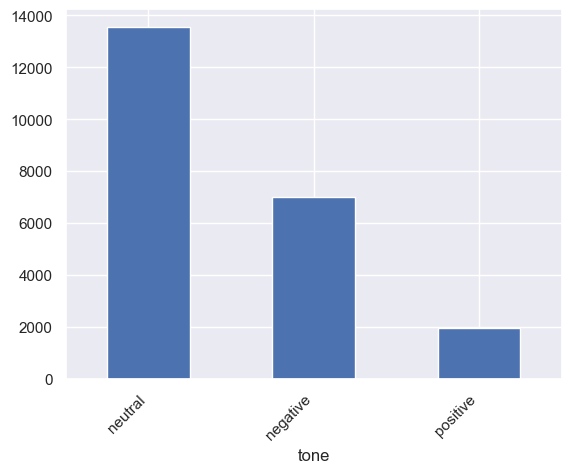

In [29]:
fig, ax = plt.subplots()
ax = df['tone'].value_counts().plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.show()

# Emotion Analysis

Checking the emotion of submissions

In [30]:
emotion_tokenizer, emotion_config, emotion_model = init_model("bhadresh-savani/distilbert-base-uncased-emotion")


In [31]:
from scipy.special import softmax
import numpy as np

emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

def emotion_analysis(text: str):
  encoded_input = emotion_tokenizer(text, max_length=512, truncation=True, return_tensors='pt')
  output = emotion_model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)

  ranking = np.argsort(scores)
  ranking = ranking[::-1]

  output = {k: 0.0 for k in emotion_labels}

  for i in range(scores.shape[0]):
      k = emotion_config.id2label[ranking[i]]
      output[k] = scores[ranking[i]]
  
  return output

emotion_analysis("Covid cases are increasing fast!")

{'sadness': 0.011512356,
 'joy': 0.87378865,
 'love': 0.0020575337,
 'anger': 0.082321994,
 'fear': 0.026589949,
 'surprise': 0.003729473}

In [32]:
for k in emotion_labels:
    df[k] = 0.0

In [34]:
for id in tqdm(df.index):
    output = emotion_analysis(df.at[id, 'comment'])
    for k in emotion_labels:
        df.at[id, k] = output[k]

100%|██████████| 22514/22514 [09:23<00:00, 39.95it/s]


In [35]:
df['emotion'] = df[emotion_labels].idxmax(axis=1)

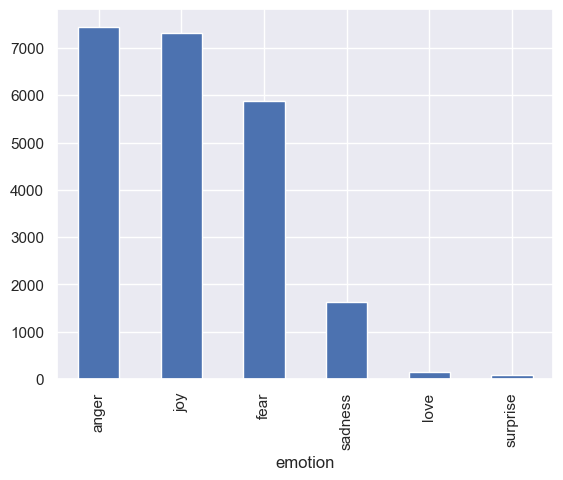

In [36]:
fig, ax = plt.subplots()
ax = df['emotion'].value_counts().plot(kind='bar')

plt.show()

In [37]:
df.to_hdf('data/comments3.h5', key='df', mode='w')
df.to_csv('data/comments3.csv', encoding='utf-8-sig')

/var/folders/lk/lhmn07j501l6rng06tjrl8cm0000gn/T/ipykernel_51574/2837991512.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['classYear', 'country', 'universityName', 'comment', 'review',
       'chapter_explanation_update', 'question_update',
       'question_explanation_update', 'qc_explanation_update', 'tone',
       'emotion'],
      dtype='object')]

  df.to_hdf('data/comments3.h5', key='df', mode='w')


# Zero-shot classification

Classification of submissions based on certain categories

In [38]:
from transformers import pipeline

zs_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [39]:
theme_labels = ['educational', 'giving feedback', 'asking a question', 'insulting', 'supporting']

def theme_analysis(text: str, multi_label=False):
  res = zs_classifier(text, theme_labels, multi_label=multi_label)

  output = {k: 0.0 for k in theme_labels}

  for k, score in zip(res['labels'], res['scores']):
      output[k] = score
  
  return output

theme_analysis("Covid cases are increasing fast!")

{'educational': 0.03408487141132355,
 'giving feedback': 0.3510622978210449,
 'asking a question': 0.23148050904273987,
 'insulting': 0.04857322946190834,
 'supporting': 0.3347991406917572}

In [40]:
for k in theme_labels:
    df[k] = 0.0

In [41]:
for id in tqdm(df.index):
    selftext = df.at[id, 'comment']
    if len(selftext) == 0:
        continue
    output = theme_analysis(selftext)
    for k in theme_labels:
        df.at[id, k] = output[k]

100%|██████████| 22514/22514 [5:54:48<00:00,  1.06it/s]    


In [42]:
df['theme'] = df[theme_labels].idxmax(axis=1)

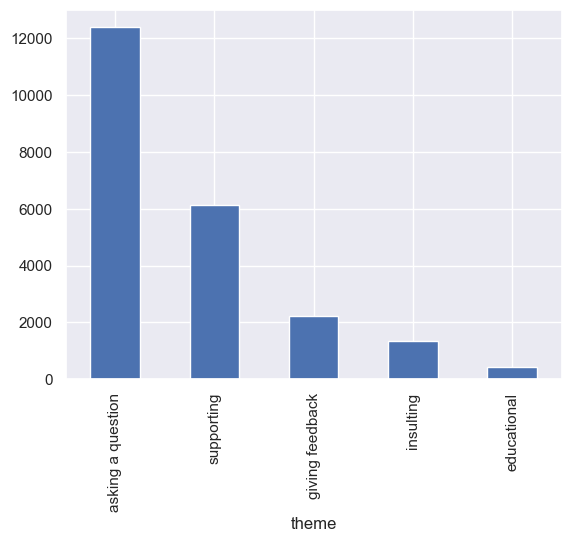

In [43]:
fig, ax = plt.subplots()
ax = df['theme'].value_counts().plot(kind='bar')

plt.show()

In [44]:
df.to_hdf('data/comments4.h5', key='df', mode='w')
df.to_csv('data/comments4.csv', encoding='utf-8-sig')

/var/folders/lk/lhmn07j501l6rng06tjrl8cm0000gn/T/ipykernel_51574/1332472547.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['classYear', 'country', 'universityName', 'comment', 'review',
       'chapter_explanation_update', 'question_update',
       'question_explanation_update', 'qc_explanation_update', 'tone',
       'emotion', 'theme'],
      dtype='object')]

  df.to_hdf('data/comments4.h5', key='df', mode='w')


# Natural Language Inference (NLI)

In NLI the model determines the relationship between two given texts. Concretely, the model takes a premise and a hypothesis and returns a class that can either be:

- **entailment**, which means the hypothesis is true.
- **contraction**, which means the hypothesis is false.
- **neutral**, which means there's no relation between the hypothesis and the premise.

### Multi-Genre NLI (MNLI)

```
Example 1:
    Premise: A man inspects the uniform of a figure in some East Asian country.
    Hypothesis: The man is sleeping.
    Label: Contradiction

Example 2:
    Premise: Soccer game with multiple males playing.
    Hypothesis: Some men are playing a sport.
    Label: Entailment
```